![](https://cdn-images-1.medium.com/max/1200/1*x7P7gqjo8k2_bj2rTQWAfg.jpeg)

# Welcome to my kernel!
- This is my 'naive' approach for the [Categorical Feature Encoding Challenge II](https://www.kaggle.com/c/cat-in-the-dat-ii) and also one of my first steps in Kaggle platform.
- This notebook has been implemented during my day-off because of the [Coronavirus](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) spread (2019-nCoV) 
- And as usual, if my work can make you feel excited, help me to <font color='red' size=3>upvote this kernel </font>on the right corner 💖💖


P/s: I come from Vietnam, so please ignore my English grammar mistakes through out this notebook 😊😊


## My work
- Have some feature distribution observations and give several conclusions
- Take some simple feature engineering
- Fine-tune a Logistic Regression


# Preparation

Import necessary libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook

# Data
Let's load the data and take some observations

In [2]:
raw_train = pd.read_csv('../input/cat-in-the-dat-ii/train.csv', index_col='id')
raw_test = pd.read_csv('../input/cat-in-the-dat-ii/test.csv', index_col='id')

print(raw_train.shape, raw_test.shape)

(600000, 24) (400000, 23)


In [3]:
raw_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,...,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,...,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,...,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,...,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,...,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


In [4]:
raw_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


# Explore Data Analysis

## Missing value

In [5]:
def plot_missing_values(df):

    cols = df.columns
    count = [df[col].isnull().sum() for col in cols]
    percent = [i/len(df) for i in count]
    missing = pd.DataFrame({'number':count, 'proportion': percent}, index=cols)
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    for i, col in enumerate(missing.columns):

        plt.subplot(1,2,i+1)
        plt.title(f'Missing values on each columns({col})')
        sns.barplot(missing[col], missing.index)
        mean = np.mean(missing[col])
        std = np.std(missing[col])
        plt.ylabel('Columns')
        plt.plot([], [], ' ', label=f'Average {col} of missing values: {mean:.2f} \u00B1 {std:.2f}')
        plt.legend()
    plt.show()
    return missing.sort_values(by='number', ascending=False)

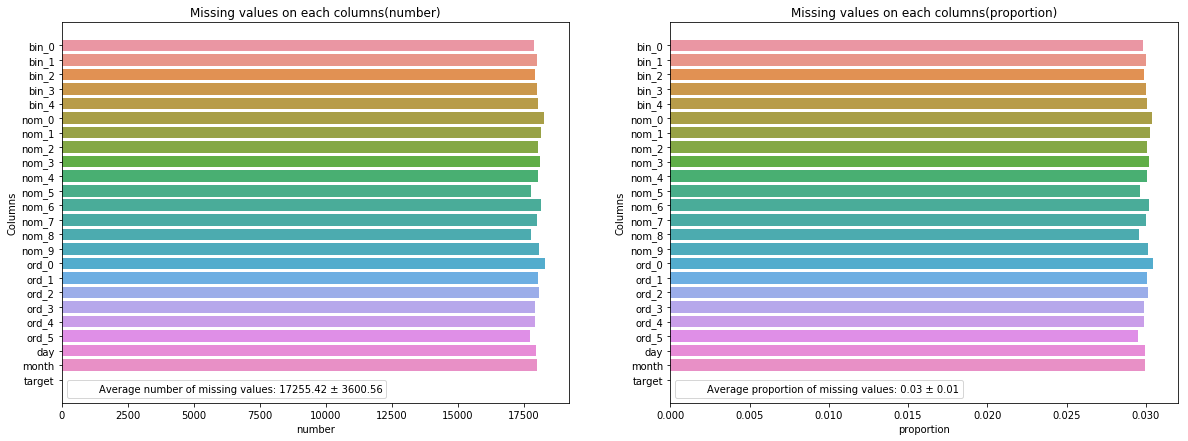

,number,proportion
ord_0,18288,0.030480
nom_0,18252,0.030420
nom_1,18156,0.030260
nom_6,18131,0.030218
nom_3,18121,0.030202


In [6]:
missing_train = plot_missing_values(raw_train)
missing_train.head()

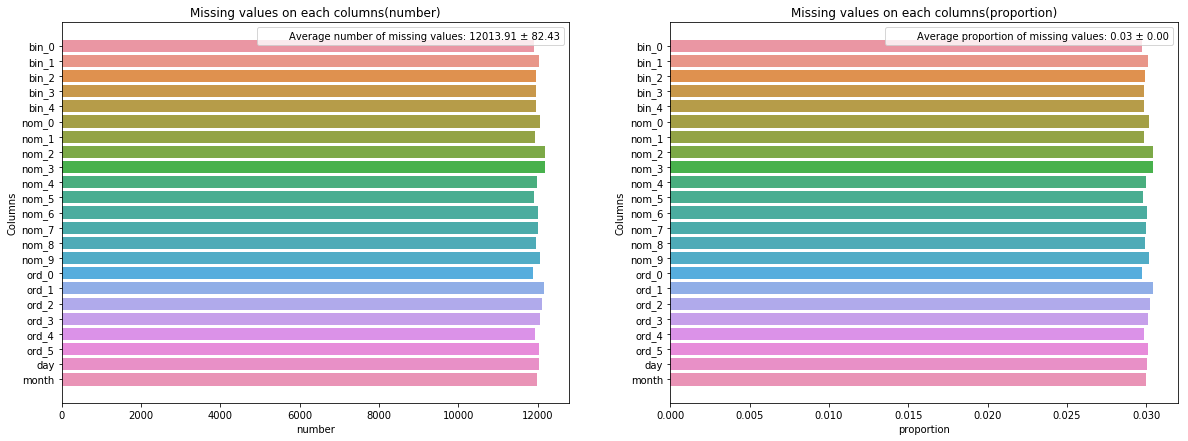

,number,proportion
nom_2,12179,0.030447
nom_3,12176,0.030440
ord_1,12167,0.030418
ord_2,12105,0.030263
nom_0,12062,0.030155


In [7]:
missing_test = plot_missing_values(raw_test)
missing_test.head()

There are misssing value on almost all columns in both train and test set. However this figure accounts for a small proportion

## Target distribution

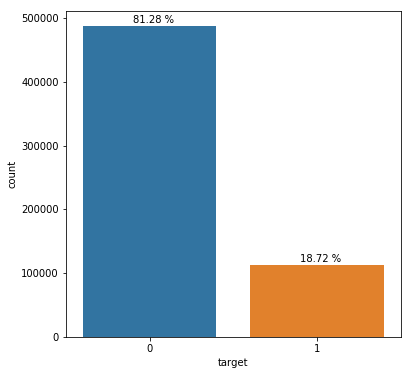

In [8]:
plt.figure(figsize=(6,6))
ax = sns.countplot(raw_train.target)

height = sum([p.get_height() for p in ax.patches])
for p in ax.patches:
        ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+5000),animated=True)

One can easily find that, this compettition is an imbalanced binary classification task with 81.28% of 0's and 18.72% of 1's.

## Heatmap
Let's plot now the train data (all the data) using a heatmap

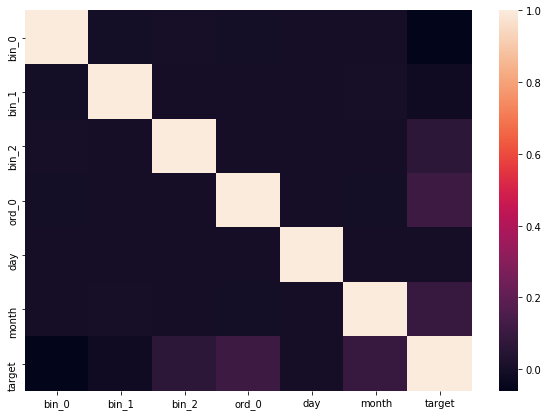

In [9]:
plt.figure(figsize=(10,7))
num_cols = raw_train.select_dtypes(exclude=['object']).columns
corr = raw_train[num_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

There're no special correlation between these features, except from the pairs of ( ord_0 - target) and ( month - target)

Take a deeper look on different target samples, I will plot separate heatmap for target values 0 and 1.

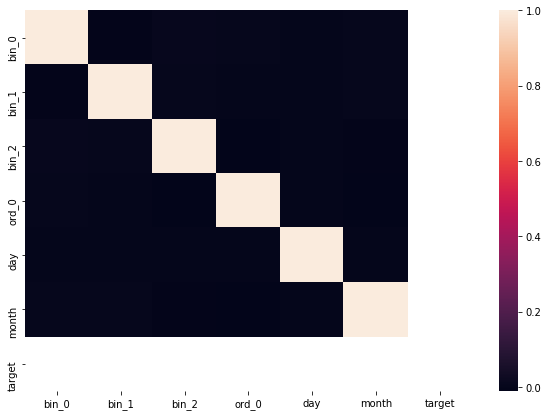

In [10]:
plt.figure(figsize=(10,7))

corr_0 = raw_train[num_cols][raw_train.target==0].corr()
sns.heatmap(corr_0, 
            xticklabels=corr_0.columns.values,
            yticklabels=corr_0.columns.values)

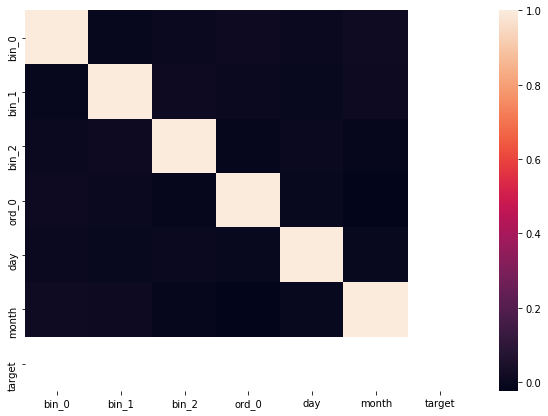

In [11]:
plt.figure(figsize=(10,7))

corr_1 = raw_train[num_cols][raw_train.target==1].corr()
sns.heatmap(corr_1, 
            xticklabels=corr_1.columns.values,
            yticklabels=corr_1.columns.values)

We get nothing special in these maps

## Density plot of numeric features

Now, I want to investigate numeric features first, using seaborn's distribution plot module

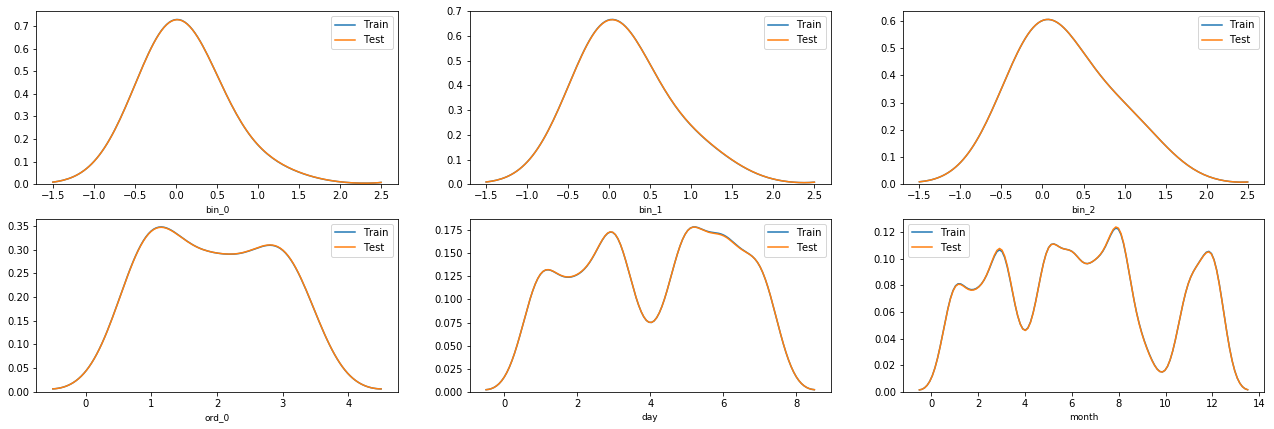

In [12]:
num_cols = raw_test.select_dtypes(exclude=['object']).columns
fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(raw_train[col].values, bw=0.5,label='Train')
    sns.kdeplot(raw_test[col].values, bw=0.5,label='Test')
   
plt.show() 

Wow, the patterns in both train and test set are almost the same in 5 numeric features, which mean that if I have a good enough model ( good performance on the training set) it seem not to find difficulty in generalization ( i.e archives relatively good performance in the test set)

> The train and test data are generated by a probability distribution over datasets called the data generating process. We typically make a set of assumptions known collectively as the i.i.d. assumptions. These assumptions are that the examples in each dataset are independent from each other, and that the train set and test set are identically distributed, drawn from the same probability distribution as each other. This assumption allows us to describe the data generating  process with a probability distribution over a single example. The same
distribution is then used to generate every train example and every test example ([Ian Goodfellow](http://www.deeplearningbook.org/))

We will have greater insight with others plot for separate distribution visualization for samples with target value 0 and 1.

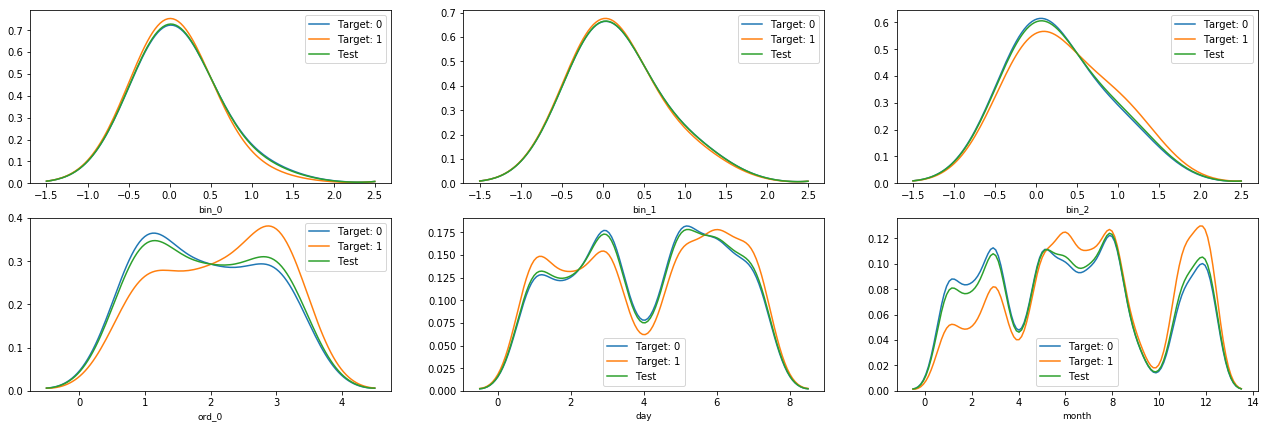

In [13]:
target0 = raw_train.loc[raw_train['target'] == 0]
target1 = raw_train.loc[raw_train['target'] == 1]

fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(target0[col].values, bw=0.5,label='Target: 0')
    sns.kdeplot(target1[col].values, bw=0.5,label='Target: 1')
    sns.kdeplot(raw_test[col].values, bw=0.5,label='Test')
    
plt.show() 

These 3 patterns are almost the same, except from the case of ord_1 and month features, the 1-target class has a slightly different distribution. That means, similar to the train data set, there will be an overwhelming number of 1-target samples compare to the rest

## Binary features
Let take some small visualizations with these bool features

Text(0.5, 0.98, 'Distribution over binary feature of train data')

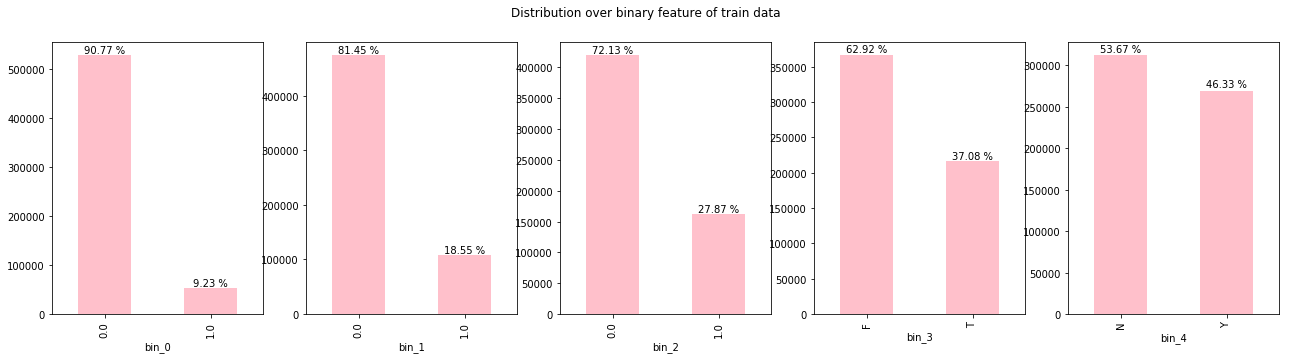

In [14]:
bin_cols = [f'bin_{i}' for i in range(5)]

fig, ax = plt.subplots(1,5, figsize=(22, 5))

for i, col in enumerate(bin_cols):
     ax0 = plt.subplot(1,5,i+1)
     raw_train[col].value_counts().plot.bar(color='pink')
     height = sum([p.get_height() for p in ax0.patches])

     for p in ax0.patches:
         ax0.text(p.get_x()+p.get_width()/2., p.get_height()+4000, f'{100*p.get_height()/height:.2f} %', ha='center')
     plt.xlabel(f'{col}')
plt.suptitle('Distribution over binary feature of train data')


Text(0.5, 0.98, 'Distribution over binary feature of test data')

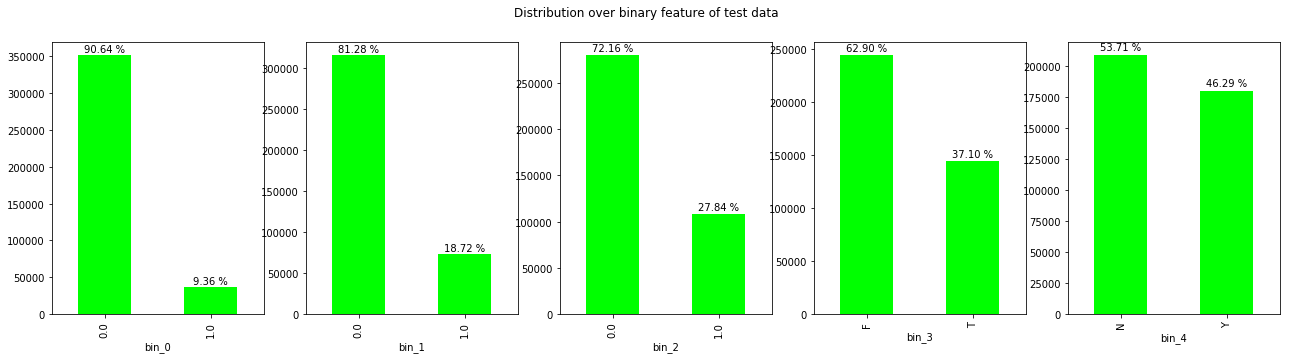

In [15]:
fig, ax = plt.subplots(1,5, figsize=(22, 5))

for i, col in enumerate(bin_cols):
     ax0 = plt.subplot(1,5,i+1)
     raw_test[col].value_counts().plot.bar(color='lime')
     height = sum([p.get_height() for p in ax0.patches])

     for p in ax0.patches:
         ax0.text(p.get_x()+p.get_width()/2., p.get_height()+4000, f'{100*p.get_height()/height:.2f} %', ha='center')
     plt.xlabel(f'{col}')
plt.suptitle('Distribution over binary feature of test data')

The pattern of binary features is very similar in both train and test set, these figures are extremely close, compare to the [Categorical Feature Encoding Challenge I](https://www.kaggle.com/c/cat-in-the-dat/) dataset (in which there still a gap between the train and test set) 

## Time features

Time features are forgotten in many machine learnning compettions. But in my personal view, time series are extremely important in statistics and  pattern recognition because many prediction problems that involve a time component
![](https://miro.medium.com/max/343/1*70cevmU8wNggGJEdLam1lw.png)

First, consider these figures as categorical features. I will plot some simple bar charts using seaborn's countplot

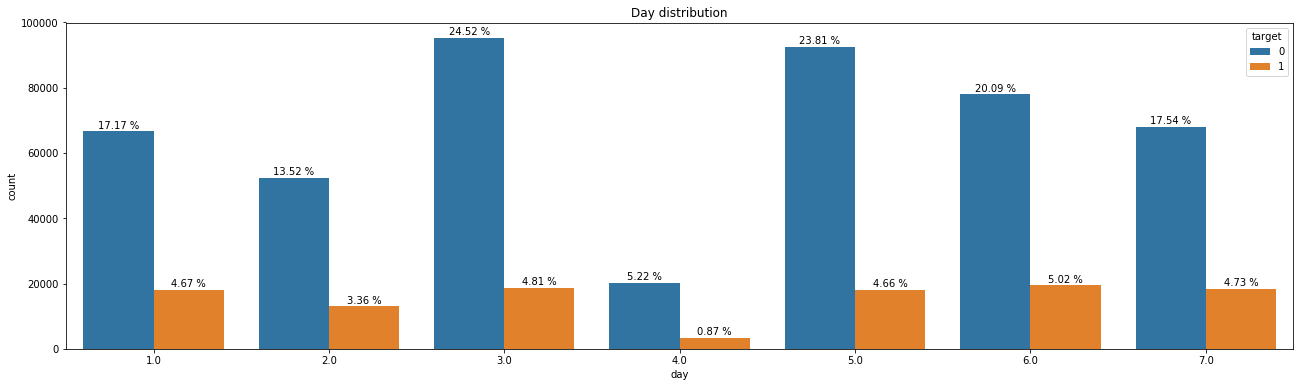

In [16]:
plt.figure(figsize=(22,6))
plt.title('Day distribution')
ax = sns.countplot(raw_train.day, hue=raw_train.target)
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+1000, f'{100*p.get_height()/height:.2f} %',ha='center')
plt.show()

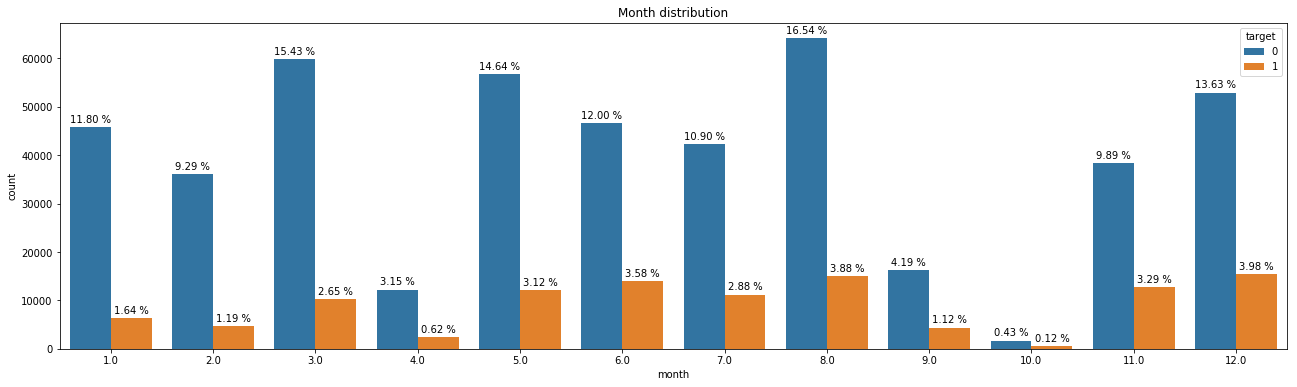

In [17]:
plt.figure(figsize=(22,6))
plt.title('Month distribution')
ax = sns.countplot(raw_train.month, hue=raw_train.target)
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+1000, f'{100*p.get_height()/height:.2f} %', ha='center')
plt.show()

It is more likely a sample will has the True target if it happens in August (16.54 %), March (15.43 %) and get the False target in December (3.98 %)

But we only see the affections of time seies data when it is plotted via line charts



### Plot trend

In [18]:
df_train = raw_train.dropna(subset=['month', 'day'])[['day', 'month', 'target']]
df_test = raw_test.dropna(subset=['month', 'day'])[['day', 'month']]
df0 = df_train[df_train.target == 0]
df1 = df_train[df_train.target == 1]

def number2datetime(df):
    time_col = '2019/' + df.month.astype(int).astype(str) + '/' + df.day.astype(int).astype(str)
    df['time'] = pd.to_datetime(time_col , format = '%Y/%m/%d')
    df = df.drop(columns=['day', 'month'])
    return df
df0 = number2datetime(df0)
df1 = number2datetime(df1)
df_test = number2datetime(df_test)

In [19]:
count0 = df0.time.value_counts()/len(df0)
count0 = count0.sort_index()
count1 = df1.time.value_counts()/len(df1)
count1 = count1.sort_index()
count_test = df_test.time.value_counts(normalize=True)

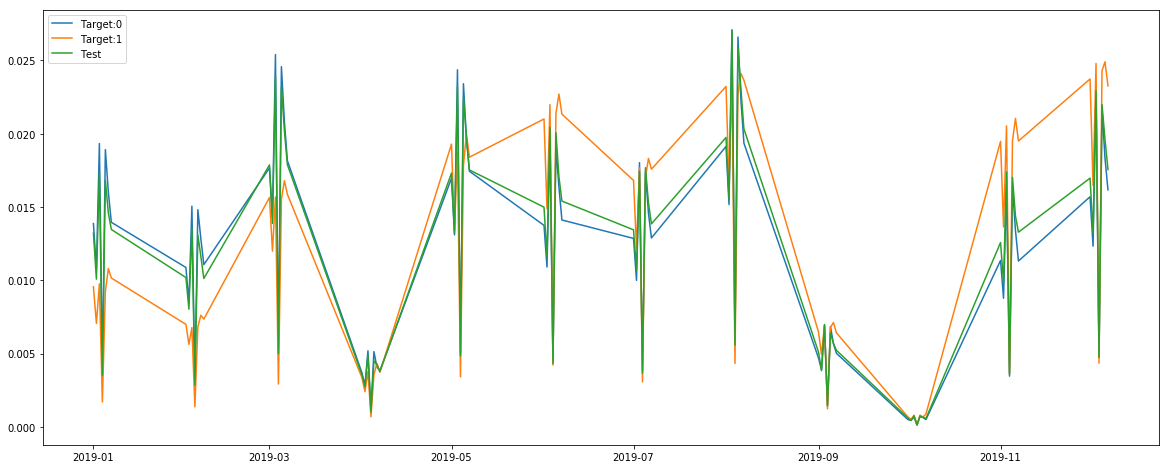

In [20]:
plt.figure(figsize=(20,8))
sns.lineplot(count0.index, count0.values, label='Target:0')
sns.lineplot(count1.index, count1.values, label='Target:1')
sns.lineplot(count_test.index, count_test.values, label='Test')
plt.legend(loc='upper left')

As being shown on the heatmap and numeric features density plots, the test set and the 0-target class in the train data set have the similar patterns whereas the 1-target samples are generated by a little bit different distribution

## Nominal features
I will divide the nominal features into 2 groups: low- (less than 10 different values) and high-cardinality nominal features (the rest)


### Low cardinality features

#### Bar charts

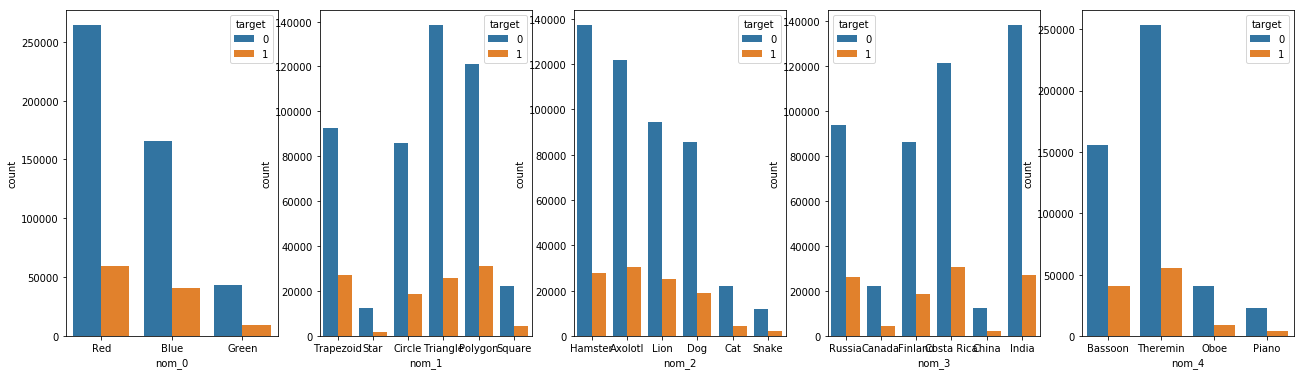

In [21]:
nom_cols = [f'nom_{i}' for i in range(5)]
fig, ax = plt.subplots(1,5, figsize=(22, 6))
for i, col in enumerate(nom_cols):
    plt.subplot(1,5,i+1)
    sns.countplot(f'nom_{i}', hue='target', data= raw_train)

plt.show()

<Figure size 1224x2520 with 0 Axes>

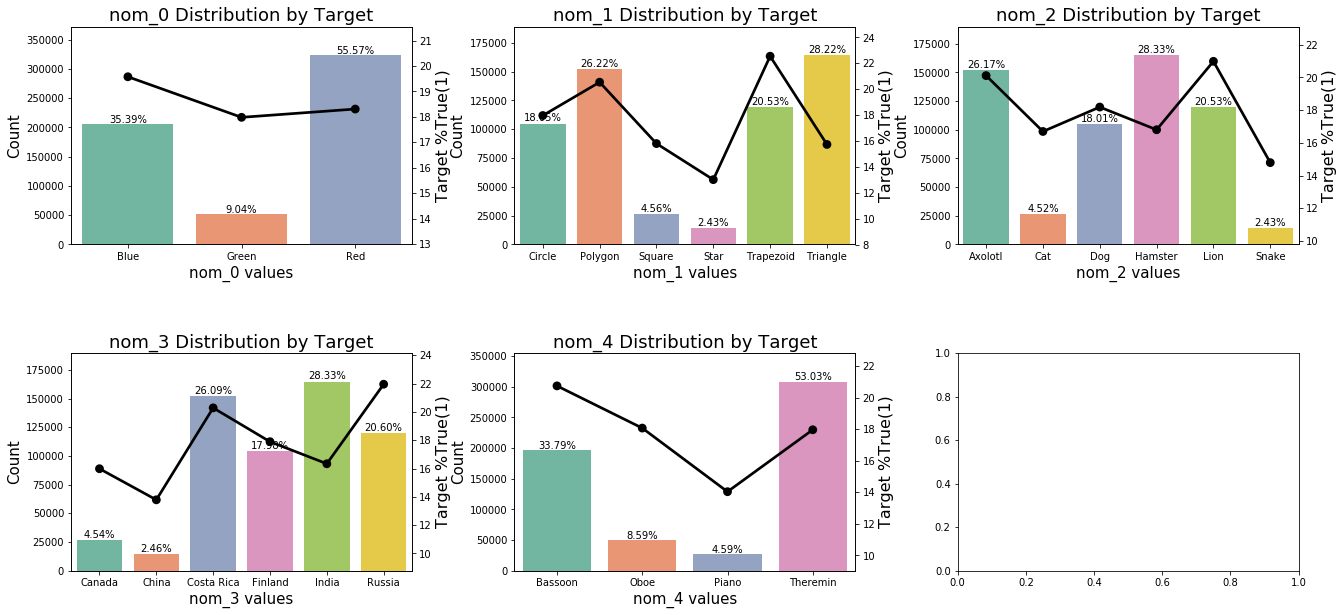

In [22]:
plt.figure(figsize=(17, 35)) 
fig, ax = plt.subplots(2,3,figsize=(22,10))

for i, col in enumerate(raw_train[nom_cols]): 
    tmp = pd.crosstab(raw_train[col], raw_train['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(2,3,i+1)
    sns.countplot(x=col, data=raw_train, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

    # twinX - to build a second yaxis
    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=16)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 2000,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


plt.subplots_adjust(hspace = 0.5, wspace=.3)
plt.show()

 Beautiful charts and provide useful information for me, too. Let get some:

- nom_0 - Blue (~20%) value have the highest % of positive values in the target
- nom_1 - Trapezoid (~23%) value have the highest % of positive values in the target
- nom_2 - Lion (~21%) value have the highest % of positive values in the target
- nom_3 - Russia (~22%) value have the highest % of positive values in the target
- nom_4 - Bassoon (~21%) value have the highest % of positive values in the target

Any special recognition?
Yes, all the values with highest % of True values on target, are not category's with highest frequency on the nominal category's
This is the same property between this and the previous [Cat in the Dat](https://www.kaggle.com/c/cat-in-the-dat/overview) competition

Now, let plot them seperately

#### Pie charts

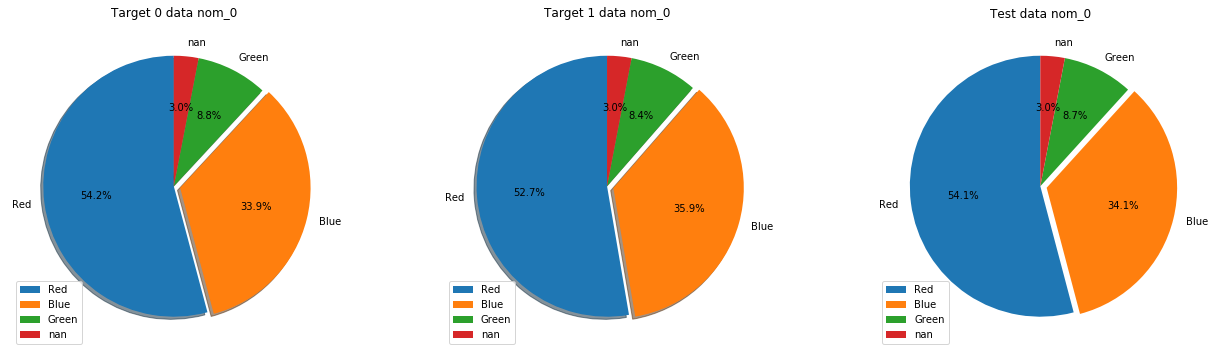

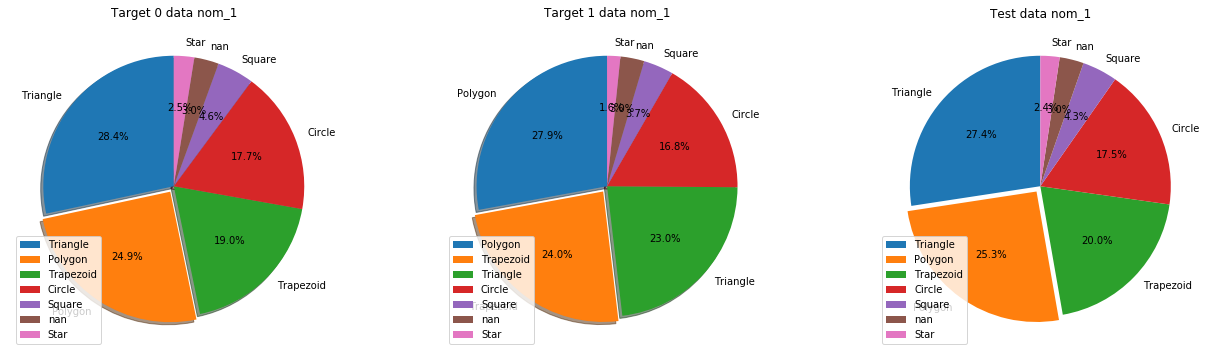

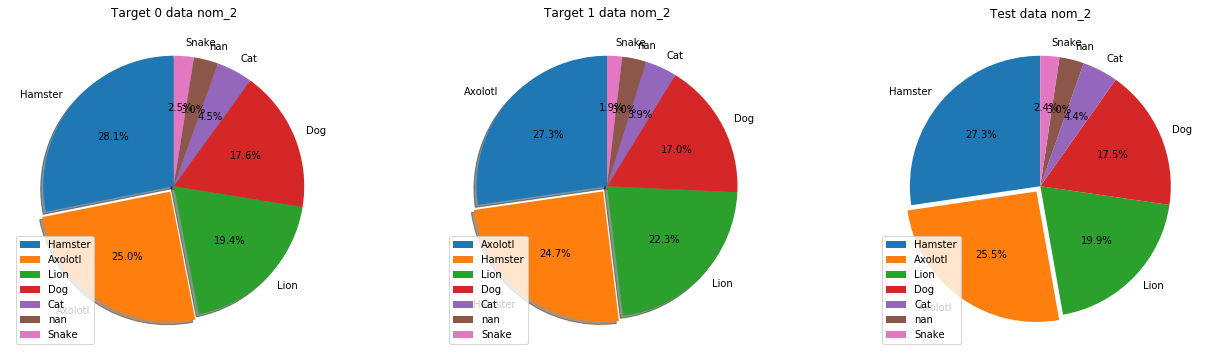

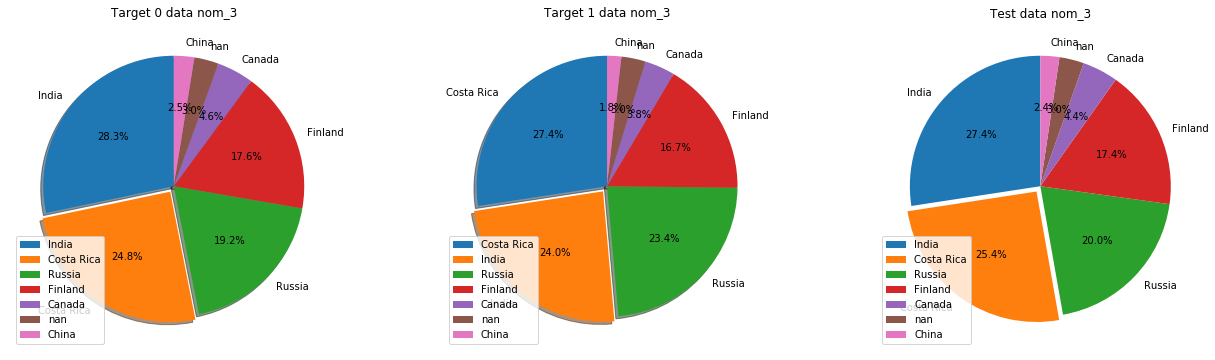

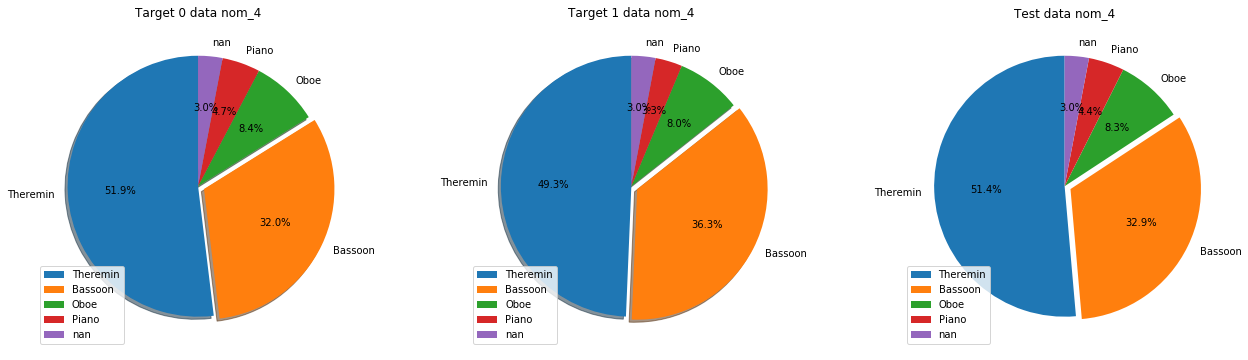

In [23]:
for col in nom_cols:
    fig, ax = plt.subplots(1,3,figsize=(22,6))
    ax[0].set_title(f'Target 0 data {col}')
    ax[1].set_title(f'Target 1 data {col}')
    ax[2].set_title(f'Test data {col}')

    explode = np.zeros(raw_train[col].nunique()+1)
    explode[1] = 0.05   
    target0_count = target0[col].value_counts(dropna=False)
    target1_count = target1[col].value_counts(dropna=False)    
    test_count = raw_test[col].value_counts(dropna=False)

    ax[0].pie(target0_count, labels=target0_count.index, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
    ax[0].legend(labels=target0_count.index,loc=3)
    ax[1].pie(target1_count, labels=target1_count.index, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
    ax[1].legend(labels=target1_count.index,loc=3)    
    ax[2].pie(test_count, labels=test_count.index, autopct='%1.1f%%', explode=explode, shadow=False, startangle=90)
    ax[2].legend(labels=test_count.index,loc=3)

As usual, the patterns of 0 target class and test set are similar whereas the 1 class samples's distribution are slightly unalike 

### High cardinality features


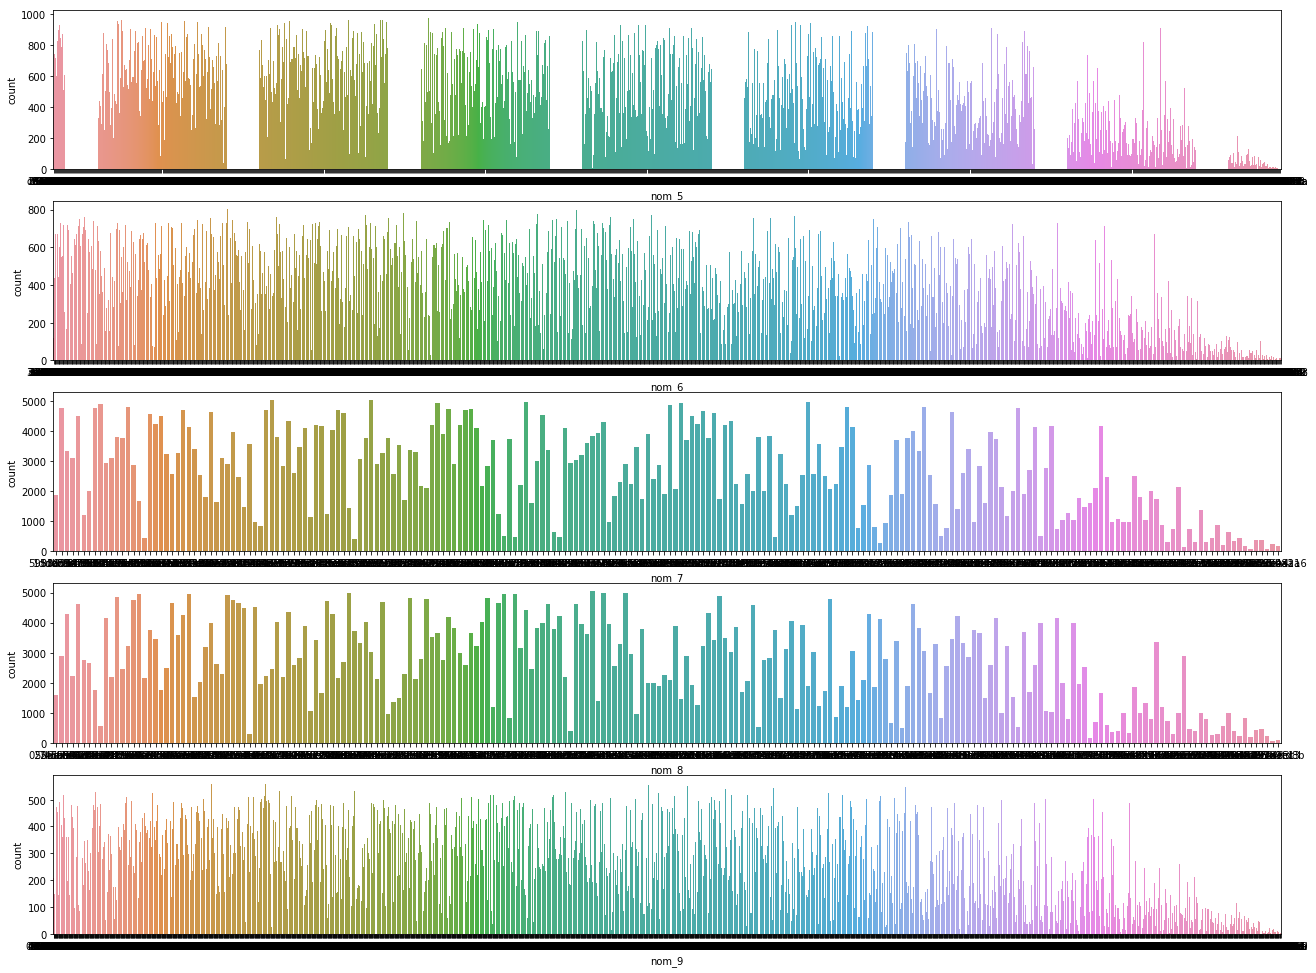

In [24]:
nom_cols = [f'nom_{i}' for i in range(5,10)]
fig, ax = plt.subplots(5,1, figsize=(22,17))
for i,col in enumerate(nom_cols):
    plt.subplot(5,1,i+1)
    sns.countplot(raw_train[col])
plt.show()

It is impossible for any conclusion when plotting high cardinality features, but I still leave them there, just because they are colorful and impressive (at least for me 😊😊😊)


## Ordinal features
Again, I will divide them into groups

### Low cardinality features

<Figure size 1224x2520 with 0 Axes>

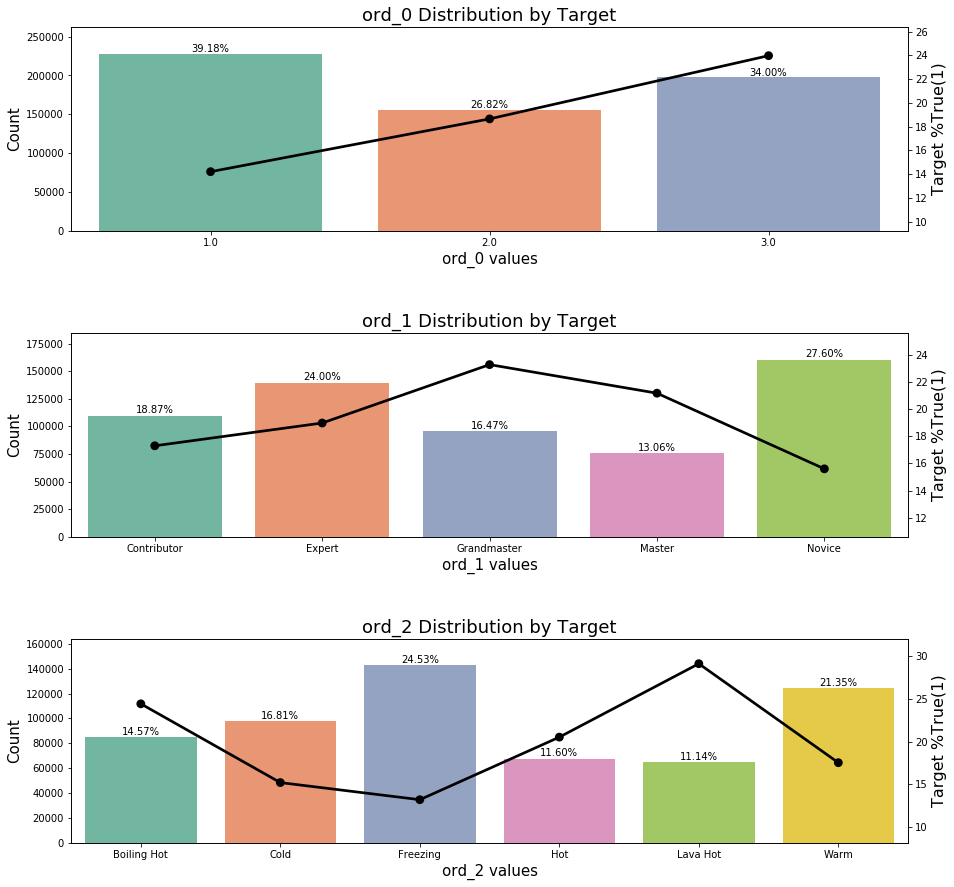

In [25]:
ord_cols = [f'ord_{i}' for i in range(3)]
plt.figure(figsize=(17, 35)) 
fig, ax = plt.subplots(3,1,figsize=(15,15))

for i, col in enumerate(raw_train[ord_cols]): 
    tmp = pd.crosstab(raw_train[col], raw_train['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(3,1,i+1)
    sns.countplot(x=col, data=raw_train, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=16)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 2000,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.subplots_adjust(hspace = 0.5, wspace=.3)
plt.show()

Grand Master accounts for a small proportion(16,47 %) but has the highest percentage of positive values in the target
Maybe data was taken from another Kaggle compettion 😍???


### High cardinality features

<Figure size 1224x2520 with 0 Axes>

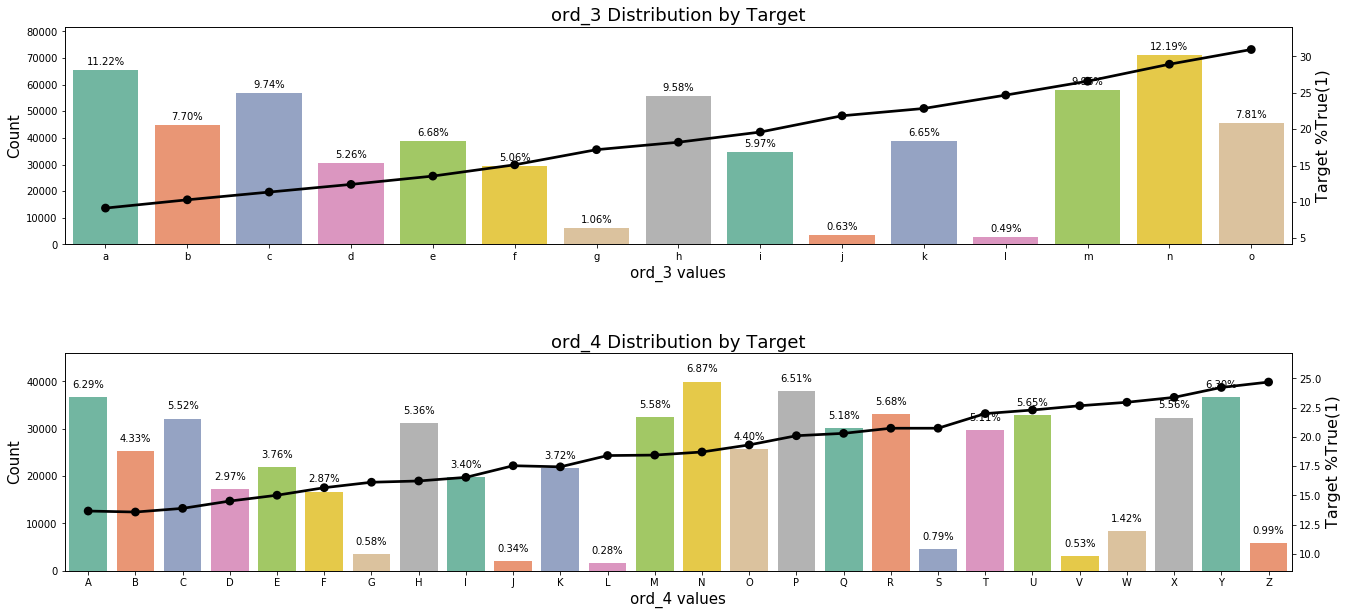

In [26]:
ord_cols = ['ord_3', 'ord_4']
plt.figure(figsize=(17, 35)) 
fig, ax = plt.subplots(2,1,figsize=(22,10))

for i, col in enumerate(raw_train[ord_cols]): 
    tmp = pd.crosstab(raw_train[col], raw_train['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(2,1,i+1)
    sns.countplot(x=col, data=raw_train, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

    # twinX - to build a second yaxis
    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=16)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 2000,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


plt.subplots_adjust(hspace = 0.5, wspace=.3)
plt.show()

Great, the frequency are varied  but look at the True values on target proportion, this line graph is covariates (i.e we can see a clearly linear relationship) which means the higher in character order, the more likely they will appear in the 1 target class

Text(0.5, 0, 'ord_5 values')

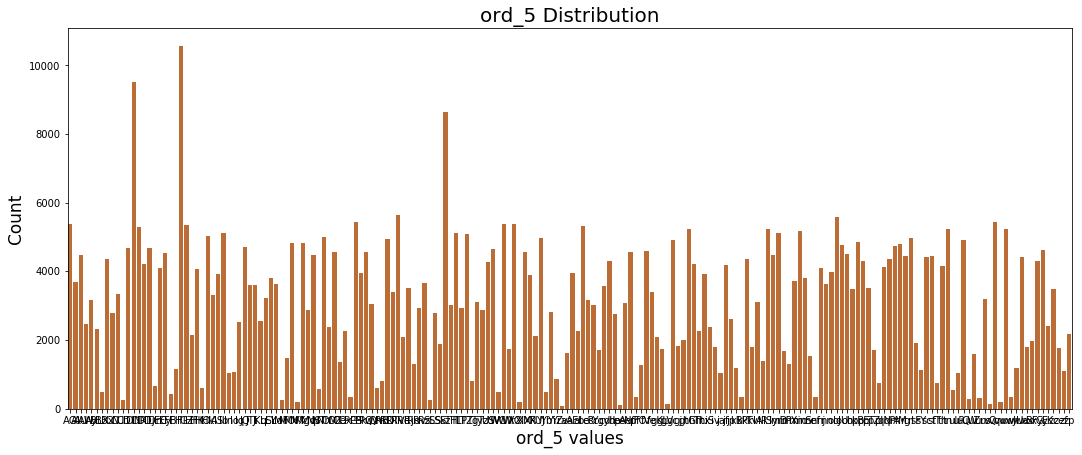

In [27]:
tmp = pd.crosstab(raw_train['ord_5'], raw_train['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)
plt.figure(figsize=(18,7))

plt.subplot()
ax = sns.countplot(x='ord_5', data=raw_train, order=list(tmp['ord_5'].values) , color='chocolate') 
ax.set_ylabel('Count', fontsize=17) # y axis label
ax.set_title('ord_5 Distribution', fontsize=20) # title label
ax.set_xlabel('ord_5 values', fontsize=17) # x axis label

That is enough for me to explore and understand the data. If you have any others useful pattern recognition, please leave some comments at the end of my kernel

P/s: There charts make me feel like they come from a IELTS writing test 😁😁😁

# Feature Engineer
I will try to extract information from these features which hopefully can be used to improve the performance of my Logistic Regression model

In [28]:
full_data = pd.concat([raw_train, raw_test], sort=False).drop(columns='target')
full_data.shape

(1000000, 23)

## XOR values

In [29]:
# Replace values which doesnt appear in both train and test set with another special value ('xor')
cate_columns = full_data.select_dtypes(include=['object']).columns
for col in cate_columns:
    train_values = set(raw_train[col].unique())
    test_values = set(raw_test[col].unique())

    xor_values = test_values - train_values 
    if xor_values:
        print(f'Replace {len(xor_values)} in {col} column')
        print('They are: ', xor_values)
        print()
        full_data.loc[full_data[col].isin(xor_values), col] = 'xor'

Replace 1 in nom_6 column
They are:  {'a885aacec'}



## Ordinal features mapping
Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed in; in this case, we use the knowledge that there is some true order to the classes themselves

In [30]:
map_ord1 = {'Novice':1, 
            'Contributor':2, 
            'Expert':4, 
            'Master':5, 
            'Grandmaster':6}
full_data.ord_1 = full_data.ord_1.map(map_ord1)

In [31]:
map_ord2 = {'Freezing':1, 
            'Cold':2, 
            'Warm':3, 
            'Hot':4, 
            'Boiling Hot':5, 
            'Lava Hot':6}
full_data.ord_2 = full_data.ord_2.map(map_ord2)

In [32]:
# Replace a character with its ASCII value
full_data['ord_3_by_ord'] = full_data.ord_3.map(ord, na_action='ignore')
map_ord3 = {key:value for value,key in enumerate(sorted(full_data.ord_3.dropna().unique()))}
full_data.ord_3 = full_data.ord_3.map(map_ord3)

In [33]:
full_data['ord_4_by_ord'] = full_data.ord_4.map(ord, na_action='ignore')
map_ord4 = {key:value for value,key in enumerate(sorted(full_data.ord_4.dropna().unique()))}
full_data.ord_4 = full_data.ord_4.map(map_ord4)

In [34]:
# ord_5 is a little bit more special(2-characters-string)
# We divide it into 2 pieces of character but also keep the orgin string and convert to categorical features by Label Encoder

full_data['ord_5_1'] = full_data.ord_5.map(lambda string: ord(string[0]), na_action='ignore')
full_data['ord_5_2'] = full_data.ord_5.map(lambda string: ord(string[1]), na_action='ignore')

map_ord5 = {key:value for value,key in enumerate(sorted(full_data.ord_5.dropna().unique()))} 
full_data.ord_5 = full_data.ord_5.map(map_ord5)

## Missing values indicator

Some columns will be imputed below so that I have to keep track of which values were missing, it really makes sense that my imputation would perform better

In [35]:
num_columns = full_data.select_dtypes(exclude=['object']).columns.drop(['bin_0', 'bin_1', 'bin_2'])
cate_columns = full_data.columns.drop(num_columns)

In [36]:
missing_num_columns = [col for col in num_columns if any(full_data[col].isnull())]
for col in missing_num_columns:
    full_data[col+'_is_missing'] = full_data[col].isnull().astype(int)

## Simple imputer and features encoding

I tried to encode cyclic feature with trigonometric functions and expect this technique can be useful to understand and extract insights from samples based upon the patterns and behaviors of the data points over a specific time period

In [37]:
time_cols = ['day', 'month']

for col in time_cols:
    full_data[col+'_sin'] = np.sin(2*np.pi*full_data[col]/7)
    full_data[col+'_cos'] = np.cos(2*np.pi*full_data[col]/12)
full_data = full_data.drop(columns=time_cols)

I will divide features in to 2 groups, the first will be one hot encoded, and the other will be retained

In [38]:
retain_cols = [f'ord_{i}' for i in range(6)] + ['day_sin', 'day_cos', 'month_sin', 'month_cos']
OH_cols = full_data.columns#.drop(retain_cols)

![](https://miro.medium.com/max/878/1*WXpoiS7HXRC-uwJPYsy1Dg.png)

One-hot encoding is a process of binarizing the categorical variable. This is done by transforming a categorical variable with n unique values into n unique columns in the datasets while keeping the number of rows the same



In [39]:
print(f"One-Hot encoding {len(OH_cols)} columns")

OH_full = pd.get_dummies(
    full_data,
    columns=OH_cols,
    drop_first=True,
    dummy_na=True,
    sparse=True,
).sparse.to_coo()

One-Hot encoding 41 columns


This produces output as a pandas dataframe.Alternatively we can use *OneHotEncoder()* method available in* sklearn* to convert out data to on-hot encoded data.
But this method produces a sparse metrix.The advantage of this methos is that is uses very less memory/cpu resourses, if one try to encode all of these features with sklearn's *OneHotEncoder()*, it pottentially cause a crash session

In [40]:
# Impute numeric features with mean value and normalize afterward 
imputer = SimpleImputer(strategy='mean')
retain_full  = pd.DataFrame(imputer.fit_transform(full_data[retain_cols]), columns=retain_cols)
retain_full = retain_full/retain_full.max()

Combine these encoded dataframe and notice that I've added a term (retain_full$^2$) which will help me to archive higher score (but also reduce the training speed)

In [41]:
encoded_full = scipy.sparse.hstack([OH_full, retain_full, retain_full**2]).tocsr()
print(encoded_full.shape)

encoded_train = encoded_full[:len(raw_train)]
encoded_test = encoded_full[len(raw_train):]

(1000000, 5905)


# Model
- In this kernel, I will implement a sklearn's Logistic Regression model

- You can also take a look at my first (and also very simple) XGBoost model for this competitions [here](https://www.kaggle.com/warkingleo2000/xgboost-with-onehot-and-label-encoding)

## Vanilla Logistic Regression
It's actually not a vanilla Logistic Regression, the C parameter (inverse of regularization strength) has been set to .03

In [42]:
model = LogisticRegression(C=0.03, max_iter=300)

Evaluate my model using 5-fold cross validation and plot the ROC curve

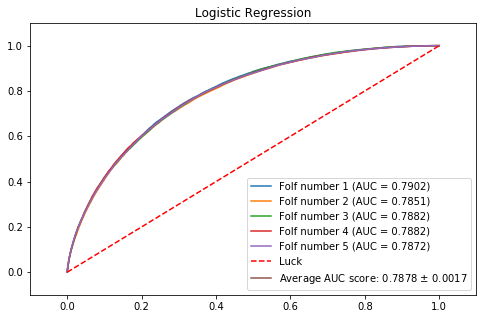

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True)

for i, (train,valid) in tqdm_notebook(enumerate(cv.split(encoded_train, raw_train.target))):
    
    model.fit(encoded_train[train], raw_train.target[train])
    valid_pred = model.predict_proba(encoded_train[valid])[:, 1]
    
    fpr, tpr, threshold = roc_curve(raw_train.target[valid], valid_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'Folf number {i+1} (AUC = {roc_auc:.4f})')
    aucs.append(roc_auc)

ax.plot([0,1], [0,1], label='Luck', linestyle='--', color='r')  
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_auc, label=f'Average AUC score: {mean_auc:.4f} $\pm$ {std_auc:.4f}')
ax.legend(loc="lower right")
ax.set(xlim=[-.1, 1.1], ylim=[-.1, 1.1], title='Logistic Regression')
plt.show()

## Parameter Tuning
Parameter estimation using grid search with cross-validation and taking the best model

In [44]:
"""
model = LogisticRegression()
param_grid = {'C' : np.logspace(-4, 4, 20), 'penalty' : ['l1', 'l2']}

# Create grid search object

clf = GridSearchCV(LogisticRegression(), scoring='roc_auc', param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

clf.fit(encoded_train, raw_train.target)

print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
print("Accuracy :",clf.best_score_)"""

'\nmodel = LogisticRegression()\nparam_grid = {\'C\' : np.logspace(-4, 4, 20), \'penalty\' : [\'l1\', \'l2\']}\n\n# Create grid search object\n\nclf = GridSearchCV(LogisticRegression(), scoring=\'roc_auc\', param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)\n\n# Fit on data\n\nclf.fit(encoded_train, raw_train.target)\n\nprint("tuned hpyerparameters :(best parameters) ",clf.best_params_)\nprint("Accuracy :",clf.best_score_)'

My GridCV requires total: 40 (candidates) x 5 (folds) = 200 (fits)

 So I comment these codes in order to avoid time consuming
 After have the best parameter combination, you can try to refit the LR to encoded data (code below)

In [45]:
"""
model = LogisticRegression(**clf.best_params_)
fig, ax = plt.subplots(figsize=(8,5))
aucs = []
cv = StratifiedKFold(n_splits=5, shuffle=True)

for i, (train,valid) in tqdm_notebook(enumerate(cv.split(encoded_train, raw_train.target))):
    
    model.fit(encoded_train[train], raw_train.target[train])
    valid_pred = model.predict_proba(encoded_train[valid])[:, 1]
    
    fpr, tpr, threshold = roc_curve(raw_train.target[valid], valid_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'Folf number {i} (AUC = {roc_auc:.4f})')
    aucs.append(roc_auc)

ax.plot([0,1], [0,1], label='Luck', linestyle='--', color='r')  
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_auc, label=f'Average AUC score: {mean_auc:.4f} $\pm$ {std_auc:.4f}')
ax.legend(loc="lower right")
ax.set(xlim=[-.1, 1.1], ylim=[-.1, 1.1], title='Logistic Regression')
plt.show()"""

'\nmodel = LogisticRegression(**clf.best_params_)\nfig, ax = plt.subplots(figsize=(8,5))\naucs = []\ncv = StratifiedKFold(n_splits=5, shuffle=True)\n\nfor i, (train,valid) in tqdm_notebook(enumerate(cv.split(encoded_train, raw_train.target))):\n    \n    model.fit(encoded_train[train], raw_train.target[train])\n    valid_pred = model.predict_proba(encoded_train[valid])[:, 1]\n    \n    fpr, tpr, threshold = roc_curve(raw_train.target[valid], valid_pred)\n    roc_auc = auc(fpr, tpr)\n    plt.plot(fpr, tpr, label = f\'Folf number {i} (AUC = {roc_auc:.4f})\')\n    aucs.append(roc_auc)\n\nax.plot([0,1], [0,1], label=\'Luck\', linestyle=\'--\', color=\'r\')  \nmean_auc = np.mean(aucs)\nstd_auc = np.std(aucs)\nax.plot(mean_auc, label=f\'Average AUC score: {mean_auc:.4f} $\\pm$ {std_auc:.4f}\')\nax.legend(loc="lower right")\nax.set(xlim=[-.1, 1.1], ylim=[-.1, 1.1], title=\'Logistic Regression\')\nplt.show()'

# Predict test set and make submission

In [46]:
%%time
model = LogisticRegression(C=0.03, max_iter=300)
model.fit(encoded_train, raw_train.target)
test_pred = model.predict_proba(encoded_test)[:, 1]

CPU times: user 43.4 s, sys: 252 ms, total: 43.6 s
Wall time: 43.6 s


In [47]:
%%time
submiss = pd.DataFrame({"id": raw_test.index, "target": test_pred})
submiss.to_csv('Phan_Viet_Hoang.csv', index=False)

CPU times: user 2.82 s, sys: 50.8 ms, total: 2.87 s
Wall time: 3.17 s


<p><font size="3" color="green">Last update on 14/2/2020</font></p> 
<p><font size="5" color="yellow">What's next?</font></p>
I will try to impove my model, try others esemble methods as well as feature engineering technique and update them in this kernel

<p><font size="3" color="red">Thank you</font> for spending time on my kernel!</p>
